In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.feature_selection import SelectFromModel

%matplotlib inline


In [4]:
def load_the_data(path):
    return pd.read_csv(path)

### Take a quick look at the data

In [5]:
path = r'C:\Users\kk\Documents\Python Projects\California Housing Price\handson-ml\datasets\housing\housing.csv'
df = load_the_data(path)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [5]:
len(df.columns)

10

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
df.ocean_proximity.unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [9]:
df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018DD5131BC8>,
      dtype=object)

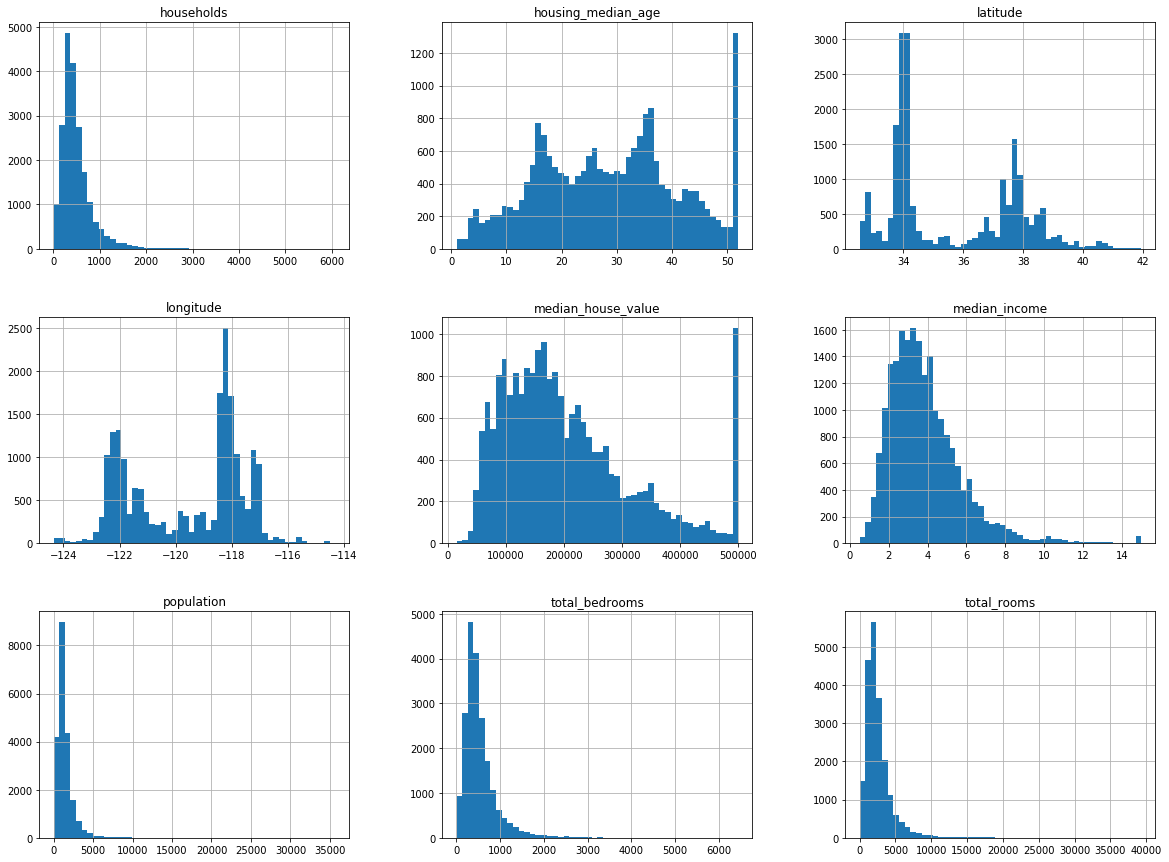

In [10]:
df.hist(bins=50, figsize = (20,15))

In [11]:
len(df[df.median_house_value.between(99000, 110000, inclusive=False)])

802

### create a test set

#### stratified shuffle split

In [6]:
#train & test set which we will be use in the project
df['median_income_cat'] = np.ceil(df.median_income/1.5)
df['median_income_cat'] = df.median_income_cat.where((df.median_income_cat)<5,5)

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index, test_index in split.split(df,df.median_income_cat):
    strat_train_set= df.loc[train_index]
    strat_test_set= df.loc[test_index]

In [9]:
strat_test_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN,5.0
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,240300.0,<1H OCEAN,4.0
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,218200.0,<1H OCEAN,3.0
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,182100.0,INLAND,3.0
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,121300.0,INLAND,3.0
...,...,...,...,...,...,...,...,...,...,...,...
20519,-121.53,38.58,33.0,4988.0,1169.0,2414.0,1075.0,1.9728,76400.0,INLAND,2.0
17430,-120.44,34.65,30.0,2265.0,512.0,1402.0,471.0,1.9750,134000.0,NEAR OCEAN,2.0
4019,-118.49,34.18,31.0,3073.0,674.0,1486.0,684.0,4.8984,311700.0,<1H OCEAN,4.0
12107,-117.32,33.99,27.0,5464.0,850.0,2400.0,836.0,4.7110,133500.0,INLAND,4.0


### Discover and Visualize

In [13]:
housing = strat_train_set.copy()
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'median_income_cat'],
      dtype='object')

#s- shows popultion and c-shows a median house value
housing.plot(kind = 'scatter',x='longitude',y='latitude',alpha=0.1,s=housing['population']/100,label='population',c='median_house_value',cmap=plt.get_cmap('jet'),figsize=(10,7))

In [14]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
median_income_cat     0.642274
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018DD68BE748>,
      dtype=object)

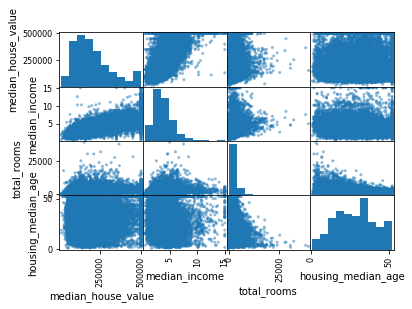

In [16]:
from pandas.plotting import scatter_matrix
att = ['median_house_value','median_income','total_rooms','housing_median_age']
scatter_matrix(strat_train_set[att])

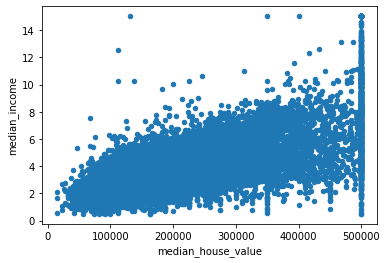

In [17]:
housing.plot(kind='scatter',x='median_house_value',y='median_income')

In [18]:
housing.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,median_income_cat
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432,-0.016243
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724,-0.078848
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110,-0.139385
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097,0.221690
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689,0.012502
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920,0.022848
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506,0.034995
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160,0.902156
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000,0.642274
median_income_cat,-0.016243,-0.078848,-0.139385,0.221690,0.012502,0.022848,0.034995,0.902156,0.642274,1.000000


### train set and labels

In [19]:
housing = strat_train_set.drop('median_house_value',axis=1)
housing_label = strat_train_set['median_house_value'].copy()

## Class & Pipelines

In [21]:
housing_num = housing.select_dtypes('float64')
housing_cat = housing['ocean_proximity']

In [22]:
rooms_ix,bedrooms_ix,population_ix, household_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self,X, y=None):
        return self
    def transform(self,X, y=None):
        rooms_per_household = X[:,rooms_ix]/X[:,household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix]/X[:,rooms_ix]
            return np.c_[X,rooms_per_household,bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household]
        
            
class RemoveNaN(TransformerMixin):
    def __init__(self,filling_strategy = 'median'):
        self.filling_strategy = filling_strategy
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if self.filling_strategy == 'median':
            for col in X.select_dtypes('float64'):
                col_median = X[col].median()
                X[col].fillna(col_median)
            return X
                
        else:
            for col in X.select_dtypes('float64'):
                col_mean = X[col].mean()
                X[col].fillna(col_mean)
            return X 
        

class ChangeObjectToInt:
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        for col in X.select_dtypes('object'):
            cat_to_int = pd.get_dummies(X[col],prefix = col)
            X = X.join(cat_to_int)
            X = X.drop(col,axis=1)
        return X
    
class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attributes_name):
        self.attributes_name = attributes_name
        
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        
        return X[self.attributes_name].values

#### Transformation Pipelines


In [23]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=2, random_state=0, n_jobs=-1)
sfm = SelectFromModel(clf, threshold=0.1)

num_attr = list(housing_num)
cat_attr = ['ocean_proximity']
num_pipeline = Pipeline([('selector',DataFrameSelector(num_attr)),
                         ('imputer',Imputer(strategy='median')),
                         #('attribs_adder',CombinedAttributesAdder()),
                         ('std_scaler',StandardScaler())
                        ])

cat_pipeline = Pipeline([('selector',DataFrameSelector(cat_attr)),
                         ('onehot',OneHotEncoder())
                        ])
## to connect two pipelines in one
full_pipeline = FeatureUnion(transformer_list=[('num_pipeline',num_pipeline),('cat_pipeline',cat_pipeline)])


fpipe = Pipeline([
    ('full', full_pipeline),
    ('selector', sfm)
                 
                 ])




housing_prepared = fpipe.fit_transform(housing, housing_label)

housing_prepared

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


<16512x8 sparse matrix of type '<class 'numpy.float64'>'
	with 132096 stored elements in Compressed Sparse Row format>

### Select and Train Model

In [11]:
lin_reg = LinearRegression()
decision_tree = DecisionTreeRegressor()
random_forest = RandomForestRegressor()
svm = SVR()

model_list = [lin_reg, decision_tree, random_forest,svm]
rmse_results = []
param_grid =[{'normalize':[True,False]},
             {'min_samples_split':[4,12],'max_features':[2,4,6,8]},
             {'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
             {'C': [1, 10, 100, 1000], 'kernel': ['linear','rbf']}]

param = [{'normalize':[True,False]},
         {'min_samples_split':randint(4,12),'max_features':randint(2,8)},
         {'n_estimators':randint(10,30),'max_features':randint(2,8)},
         {'C': randint(500,2000), 'kernel': ['linear','rbf'],'gamma':[0.0001,0.0005,0.001]}]

for c,model in enumerate(model_list):
    #rmse on training set
    model.fit(housing_prepared,housing_label)
    housing_prediction = model.predict(housing_prepared)
    rmse_training = np.sqrt(mean_squared_error(housing_label,housing_prediction))
    #rmse on validation set
    scores = cross_val_score(model,housing_prepared,housing_label,scoring='neg_mean_squared_error')
    rmse_validation = np.sqrt(-scores)
    #grid serach
    grid_search = GridSearchCV(model,param_grid[c],scoring='neg_mean_squared_error')
    grid_search.fit(housing_prepared,housing_label)
    grid_results = grid_search.cv_results_
    rmse_grid = min(np.sqrt(-grid_results['mean_test_score']))
    #randomized search
    random_search = RandomizedSearchCV(model,param[c],scoring='neg_mean_squared_error')
    random_search.fit(housing_prepared,housing_label)
    random_results = random_search.cv_results_
    rmse_random = min(np.sqrt(-random_results['mean_test_score']))
    rmse_results.append({'model_name':str(model_list[c]).split('(')[0],'val_rmse:':np.mean(rmse_validation),'train_rmse':rmse_training,'rmse_grid':rmse_grid, 'rmse_randomized':rmse_random})
pd.DataFrame(rmse_results)
    

    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.

,model_name,val_rmse:,train_rmse,rmse_grid,rmse_randomized
0,LinearRegression,70317.697529,69958.399403,70317.812617,70317.812617
1,DecisionTreeRegressor,71901.260736,0.000000,65753.272205,67227.883480
2,RandomForestRegressor,53549.689641,22229.400150,51035.625839,51495.295941
3,SVR,118699.611696,118586.110345,71432.579370,71319.844179


In [12]:
rmse = pd.DataFrame(rmse_results)
rmse.to_csv('rmse_train.csv')

## Test 

In [56]:
#everything in one pipeline: data preparation and model
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=2, random_state=0, n_jobs=-1)
sfm = SelectFromModel(clf, threshold=0.1)
random_forest = RandomForestRegressor(max_features = 6, n_estimators = 30)

num_attr = list(housing_num)
cat_attr = ['ocean_proximity']
num_pipeline = Pipeline([('selector',DataFrameSelector(num_attr)),
                         ('imputer',Imputer(strategy='median')),
                         #('attribs_adder',CombinedAttributesAdder()),
                         ('std_scaler',StandardScaler())
                        ])

cat_pipeline = Pipeline([('selector',DataFrameSelector(cat_attr)),
                         ('onehot',OneHotEncoder())
                        ])
## to connect two pipelines in one
full_pipeline = FeatureUnion(transformer_list=[('num_pipeline',num_pipeline),('cat_pipeline',cat_pipeline)])


fpipe = Pipeline([
    ('full', full_pipeline),
    ('selector', sfm),
    ('rf',random_forest)
                 
                 ])




housing_prepared = fpipe.fit(housing, housing_label)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [55]:
housing_prediction = housing_prepared.predict(housing_test)
rmse_test = np.sqrt(mean_squared_error(housing_label_test,housing_prediction))
rmse_test

48508.85670670461

In [57]:
housing_prepared

Pipeline(memory=None,
         steps=[('full',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('num_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  DataFrameSelector(attributes_name=['longitude',
                                                                                                     'latitude',
                                                                                                     'housing_median_age',
                                                                                                     'total_rooms',
                                                                                                     'total_bedrooms',
                                                                                                     'populatio

In [32]:
#pipeline for data preparation plus seperate model
housing_test = strat_test_set.copy()

housing_test = strat_test_set.drop('median_house_value',axis=1)
housing_label_test = strat_test_set['median_house_value'].copy()

housing_prepared_test = fpipe.transform(housing_test)

random_forest = RandomForestRegressor(max_features = 6, n_estimators = 30)
random_forest.fit(housing_prepared,housing_label)
housing_prediction = random_forest.predict(housing_prepared_test)
rmse_test = np.sqrt(mean_squared_error(housing_label_test,housing_prediction))
rmse_test


48377.299927407425

In [20]:
for score, param in zip(grid_results['mean_test_score'],grid_results['params']):
    print(np.sqrt(-score),param)

63913.79671265874 {'max_features': 2, 'n_estimators': 3}
56273.68590309125 {'max_features': 2, 'n_estimators': 10}
53904.3614641382 {'max_features': 2, 'n_estimators': 30}
60732.92013240154 {'max_features': 4, 'n_estimators': 3}
53003.4300213179 {'max_features': 4, 'n_estimators': 10}
51240.26690111831 {'max_features': 4, 'n_estimators': 30}
60942.79054925182 {'max_features': 6, 'n_estimators': 3}
52673.35189717745 {'max_features': 6, 'n_estimators': 10}
51095.83680836735 {'max_features': 6, 'n_estimators': 30}
60451.73527219596 {'max_features': 8, 'n_estimators': 3}
53621.732746493304 {'max_features': 8, 'n_estimators': 10}
51817.15315956504 {'max_features': 8, 'n_estimators': 30}


## Exercises

### SVM


In [ ]:
params =  [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
grid_svm = GridSearchCV(svm,params,cv=5,scoring='neg_mean_squared_error')
grid_svm.fit(housing_prepared,housing_label)
grid_results = grid_svm.cv_results_
rmse_svr = min(np.sqrt(-grid_results['mean_test_score']))

In [ ]:
for mean, param in zip(np.sqrt(-grid_results['mean_test_score']),grid_results['params']):
    print(mean,param)

In [ ]:
pd.DataFrame(rmse_results)

## GridSearchCV for transformer -> CombinedAttributesAdder

In [ ]:
# create pipeline with a scaler 
combined = CombinedAttributesAdder()
steps = [('combined_attributes',combined),('random_forest',random_forest)]
pipeline = Pipeline(steps)
#parameters
param =  {'combined_attributes__add_bedrooms_per_room': [True,False]}
#do search
grid_search_extra_param = GridSearchCV(pipeline,param,cv=5,scoring='neg_mean_squared_error')
grid_search_extra_param.fit(housing_prepared.toarray(), housing_label)
grid_results = grid_search_extra_param.cv_results_
grid_results['mean_test_score']
rmse_grid_extra_param = min(np.sqrt(-grid_results['mean_test_score']))
rmse_grid_extra_param



